In [80]:
import numpy as np
import pandas as pd

from typing import List, Tuple
import matplotlib.pyplot as plt
import math

from sklearn.datasets import fetch_openml
from sklearn.neighbors import KNeighborsClassifier, NearestCentroid
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.inspection import DecisionBoundaryDisplay


# Fix the random seed for reproducibility
# !! Important !! : do not change this
# hw1_seed = 1234
# np.random.seed(hw1_seed)  
# pd.options.mode.chained_assignment = None 

In [38]:
from lime import lime_tabular

In [4]:
from ucimlrepo import fetch_ucirepo 
  
# fetch dataset 
diabetes_130_us_hospitals_for_years_1999_2008 = fetch_ucirepo(id=296) 
  
# data (as pandas dataframes) 
X = diabetes_130_us_hospitals_for_years_1999_2008.data.features 
y = diabetes_130_us_hospitals_for_years_1999_2008.data.targets 
  
# metadata 
print(diabetes_130_us_hospitals_for_years_1999_2008.metadata) 
  
# variable information 
print(diabetes_130_us_hospitals_for_years_1999_2008.variables) 

## testing splits ##

## 20 percent set aside
X_temp, X_te, y_temp, y_te = train_test_split(X, y, 
                                    test_size=0.20, random_state=1234, shuffle=True)

## that 75/25 split for the end 
X_tr, X_val, y_tr, y_val = train_test_split(X_temp, y_temp, 
                                    test_size=0.25, random_state=1234, shuffle=True)


X_tr


{'uci_id': 296, 'name': 'Diabetes 130-US Hospitals for Years 1999-2008', 'repository_url': 'https://archive.ics.uci.edu/dataset/296/diabetes+130-us+hospitals+for+years+1999-2008', 'data_url': 'https://archive.ics.uci.edu/static/public/296/data.csv', 'abstract': 'The dataset represents ten years (1999-2008) of clinical care at 130 US hospitals and integrated delivery networks. Each row concerns hospital records of patients diagnosed with diabetes, who underwent laboratory, medications, and stayed up to 14 days. The goal is to determine the early readmission of the patient within 30 days of discharge.\nThe problem is important for the following reasons. Despite high-quality evidence showing improved clinical outcomes for diabetic patients who receive various preventive and therapeutic interventions, many patients do not receive them. This can be partially attributed to arbitrary diabetes management in hospital environments, which fail to attend to glycemic control. Failure to provide pro

/opt/miniconda3/envs/cs178/lib/python3.12/site-packages/ucimlrepo/fetch.py:97: DtypeWarning: Columns (10) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(data_url)


,race,gender,age,weight,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,payer_code,medical_specialty,...,examide,citoglipton,insulin,glyburide-metformin,glipizide-metformin,glimepiride-pioglitazone,metformin-rosiglitazone,metformin-pioglitazone,change,diabetesMed
48004,AfricanAmerican,Female,[60-70),NaN,1,1,7,2,NaN,NaN,...,No,No,Steady,No,No,No,No,No,Ch,Yes
66310,Caucasian,Male,[70-80),NaN,1,1,7,4,MC,NaN,...,No,No,No,No,No,No,No,No,No,Yes
60905,Caucasian,Female,[70-80),NaN,1,1,7,3,HM,NaN,...,No,No,Steady,No,No,No,No,No,Ch,Yes
1873,Caucasian,Female,[70-80),NaN,3,1,1,2,NaN,Surgery-General,...,No,No,No,No,No,No,No,No,No,No
38252,Caucasian,Female,[50-60),NaN,1,6,7,3,MD,InternalMedicine,...,No,No,No,No,No,No,No,No,No,Yes
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
56803,AfricanAmerican,Male,[20-30),NaN,1,1,7,11,DM,NaN,...,No,No,Down,No,No,No,No,No,Ch,Yes
60682,Caucasian,Male,[70-80),NaN,1,6,1,7,NaN,Emergency/Trauma,...,No,No,Down,No,No,No,No,No,Ch,Yes
4596,Caucasian,Female,[70-80),NaN,1,3,7,4,NaN,Orthopedics,...,No,No,No,No,No,No,No,No,No,Yes
19756,AfricanAmerican,Male,[40-50),NaN,1,1,7,2,NaN,InternalMedicine,...,No,No,No,No,No,No,No,No,No,Yes


In [111]:
# Rebecca summary statistic rewriting
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer

X = X.replace("?", np.nan)
y = y.replace("?", np.nan)

for col in X.columns:
    X[col] = X[col].fillna(X[col].mode()[0])

#print(X.dtypes.value_counts())

#categorical = X.select_dtypes(include=['object']).columns.tolist()
#numerical = X.select_dtypes(include=['int64']).columns.tolist()
categorical = [col for col in X.columns if X[col].dtype == 'object']
numerical = [col for col in X.columns if pd.api.types.is_numeric_dtype(X[col])]
#print(categorical)
cat_summary = []
for col in categorical:
    mode = X[col].mode().iloc[0] if not X[col].mode().empty else np.nan
    num_unique = X[col].nunique(dropna=True)
    if not pd.isna(mode) and not pd.isna(num_unique):
        cat_summary.append({
            'feature' : col,
            'mode' : mode,
            'num_unique': num_unique
        })
cat_summary_table = pd.DataFrame(cat_summary)

num_summary = []
for col in numerical:

    data = X[col]
    data = pd.to_numeric(data, errors='coerce')

    if data.notna().any():
        col_range = data.max() - data.min()
        std = data.std()
        var = data.var()
        mean = data.mean()
        mode = data.mode().iloc[0] if not data.mode().empty else np.nan

    num_summary.append({'feature':col, 'range':col_range, 'std': std, 'var': var, 'mean': mean, 'mode': mode})

num_summary_table = pd.DataFrame(num_summary)
#print("Categorical")
#print(cat_summary_table)
print("Numerical")
print(num_summary_table)


Numerical
                     feature  range        std         var       mean  mode
0          admission_type_id      7   1.445403    2.089189   2.024006     1
1   discharge_disposition_id     27   5.280166   27.880148   3.715642     1
2        admission_source_id     24   4.064081   16.516753   5.754437     7
3           time_in_hospital     13   2.985108    8.910868   4.395987     3
4         num_lab_procedures    131  19.674362  387.080530  43.095641     1
5             num_procedures      6   1.705807    2.909777   1.339730     0
6            num_medications     80   8.127566   66.057332  16.021844    13
7          number_outpatient     42   1.267265    1.605961   0.369357     0
8           number_emergency     76   0.930472    0.865779   0.197836     0
9           number_inpatient     21   1.262863    1.594824   0.635566     0
10          number_diagnoses     15   1.933600    3.738810   7.422607     9


0.43544768175043813
0.4336952783373459


[Text(0.5, 0.8333333333333334, 'x[9] <= -0.11\ngini = 0.575\nsamples = 61059\nvalue = [6832, 21379, 32848]'),
 Text(0.25, 0.5, 'x[10] <= -0.995\ngini = 0.525\nsamples = 40455\nvalue = [3427, 12189, 24839]'),
 Text(0.375, 0.6666666666666667, 'True  '),
 Text(0.125, 0.16666666666666666, 'gini = 0.45\nsamples = 9666\nvalue = [614.0, 2286.0, 6766.0]'),
 Text(0.375, 0.16666666666666666, 'gini = 0.544\nsamples = 30789\nvalue = [2813, 9903, 18073]'),
 Text(0.75, 0.5, 'x[9] <= 0.675\ngini = 0.623\nsamples = 20604\nvalue = [3405, 9190, 8009]'),
 Text(0.625, 0.6666666666666667, '  False'),
 Text(0.625, 0.16666666666666666, 'gini = 0.603\nsamples = 11796\nvalue = [1518, 4918, 5360]'),
 Text(0.875, 0.16666666666666666, 'gini = 0.628\nsamples = 8808\nvalue = [1887.0, 4272.0, 2649.0]')]

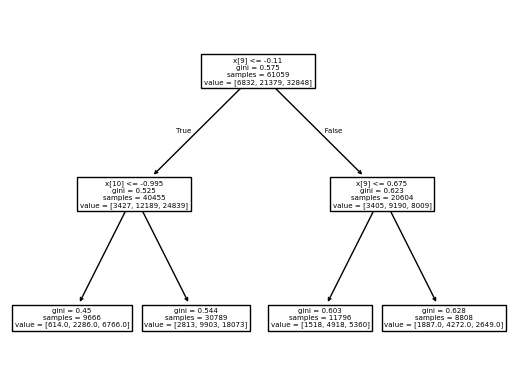

In [6]:
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
#3 order ; one hot encoding <- splits categorical into more features 1/0 if yes/no and Standard scaler for scaling data


# replacing ? with NAN and replacing NAN with the mode
X = X.replace("?", np.nan)
y = y.replace("?", np.nan)

for col in X.columns:
    X[col] = X[col].fillna(X[col].mode()[0])


categorical = X_tr.select_dtypes(include=['object']).columns.tolist()
numerical = X_tr.select_dtypes(include=['int64']).columns.tolist()

encoder = OneHotEncoder(handle_unknown='ignore')
scaler = StandardScaler()

##### COL TRANSFORMER NUM AND CAT COLUMNS <- joins them tgt and applies scaler and encoder
preproc = ColumnTransformer(transformers = [('num', scaler, numerical), ('cat', encoder, categorical)])
X_tr_2 = preproc.fit_transform(X_tr)
X_val_2 = preproc.transform(X_val)
X_te_2 = preproc.transform(X_te)

hw1_seed = 1234
clf = DecisionTreeClassifier(max_depth=2, random_state=hw1_seed)
clf.fit(X_tr_2, y_tr)

clf_err_tr = 1-clf.score(X_tr_2, y_tr)
clf_err_val = 1-clf.score(X_val_2, y_val)

print(clf_err_tr)
print(clf_err_val)

plot_tree(clf)

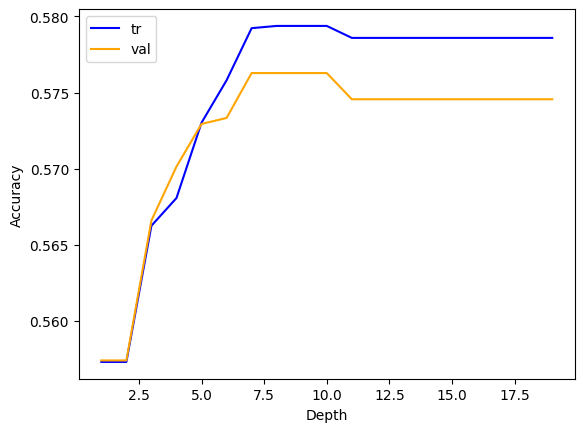

In [7]:
# decision tree w/ different max_depths
training_curve = []
testing_curve = []
max_depths = np.arange(1,20,1)
for depth in max_depths:
    clf = DecisionTreeClassifier(criterion = 'entropy', max_depth=depth, random_state=hw1_seed, max_leaf_nodes=50, min_samples_leaf = 95)
    clf.fit(X_tr_2, y_tr)

    clf_acc_tr = clf.score(X_tr_2, y_tr)
    clf_acc_val = clf.score(X_val_2, y_val)
    training_curve.append(clf_acc_tr)
    testing_curve.append(clf_acc_val)
    
plt.plot(max_depths, training_curve, label='tr', color = 'blue')
plt.plot(max_depths, testing_curve, label='val', color = 'orange')
plt.xlabel('Depth')
plt.ylabel('Accuracy')
plt.legend()

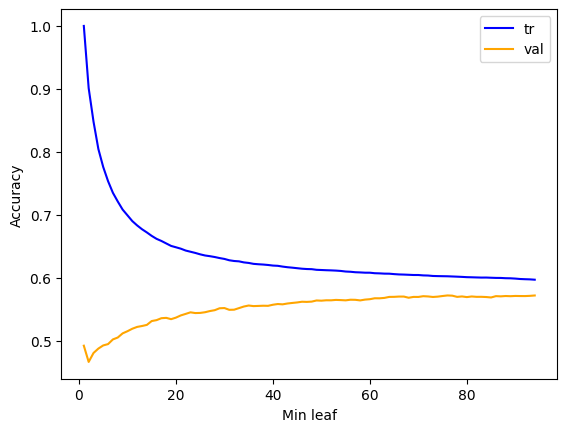

In [8]:
training_curve = []
testing_curve = []
min_leaf_samples = np.arange(1,95,1)
for min_leaf in min_leaf_samples:
    clf = DecisionTreeClassifier(criterion='gini', min_samples_leaf=min_leaf, random_state=hw1_seed)
    clf.fit(X_tr_2, y_tr)

    clf_acc_tr = clf.score(X_tr_2, y_tr)
    clf_acc_val = clf.score(X_val_2, y_val)
    training_curve.append(clf_acc_tr)
    testing_curve.append(clf_acc_val)
    
plt.plot(min_leaf_samples, training_curve, label='tr', color = 'blue')
plt.plot(min_leaf_samples, testing_curve, label='val', color = 'orange')
plt.xlabel('Min leaf')
plt.ylabel('Accuracy')
plt.legend()

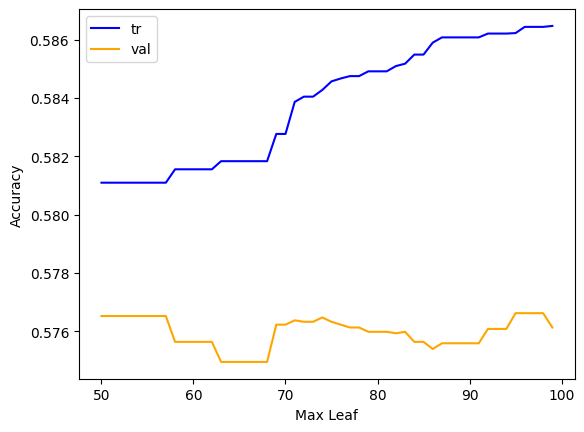

In [9]:
training_curve = []
testing_curve = []
max_leaves = np.arange(50,100)
for max_l in max_leaves:
    clf = DecisionTreeClassifier(max_leaf_nodes=max_l, random_state=hw1_seed)
    clf.fit(X_tr_2, y_tr)

    clf_acc_tr = clf.score(X_tr_2, y_tr)
    clf_acc_val = clf.score(X_val_2, y_val)
    training_curve.append(clf_acc_tr)
    testing_curve.append(clf_acc_val)
    
plt.plot(max_leaves, training_curve, label='tr', color = 'blue')
plt.plot(max_leaves, testing_curve, label='val', color = 'orange')
plt.xlabel('Max Leaf')
plt.ylabel('Accuracy')
plt.legend()

In [10]:
#amy
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
#3 order ; one hot encoding <- splits categorical into more features 1/0 if yes/no and Standard scaler for scaling data


# replacing ? with NAN and replacing NAN with the mode
X = X.replace("?", np.nan)
y = y.replace("?", np.nan)

for col in X.columns:
    X[col] = X[col].fillna(X[col].mode()[0])


categorical = X_tr.select_dtypes(include=['object']).columns.tolist()
numerical = X_tr.select_dtypes(include=['int64']).columns.tolist()

encoder = OneHotEncoder(handle_unknown='ignore')
# X_tr_cat = encoder.fit_transform(X_tr[categorical])
# X_val_cat = encoder.fit_transform(X_val[categorical])
# X_te_cat = encoder.fit_transform(X_te[categorical])

scaler = StandardScaler()
# X_tr_num = encoder.fit_transform(X_tr[categorical])
# X_val_num = encoder.fit_transform(X_val[categorical])
# X_te_num = encoder.fit_transform(X_te[categorical])

##### COL TRANSFORMER NUM AND CAT COLUMNS <- joins them tgt and applies scaler and encoder
preproc = ColumnTransformer(transformers = [('num', scaler, numerical), ('cat', encoder, categorical)])
X_tr_2 = preproc.fit_transform(X_tr)
X_val_2 = preproc.transform(X_val)
X_te_2 = preproc.transform(X_te)


accs = []
# errs = []
k_vals = [1, 10, 50, 100, 500, 1000] ## 1-50 = 7.5 mins, 1-1000+ = 11.5 mins
for i, k in enumerate(k_vals):
    print(k)
    knn = KNeighborsClassifier(n_neighbors=k)

    knn.fit(X_tr_2, y_tr)
    pred = knn.predict(X_val_2)
    acc = accuracy_score(y_val, pred)

    accs.append(acc)
    # errs.append(1-acc)
## TODO: some of that ravel error stuff ? doesnt matter long run tho
plt.plot(k_vals, accs, marker='o', label='Accuracy')
plt.legend()
plt.show()

1


/opt/miniconda3/envs/cs178/lib/python3.12/site-packages/sklearn/neighbors/_classification.py:239: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


10


/opt/miniconda3/envs/cs178/lib/python3.12/site-packages/sklearn/neighbors/_classification.py:239: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


50


/opt/miniconda3/envs/cs178/lib/python3.12/site-packages/sklearn/neighbors/_classification.py:239: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


100


/opt/miniconda3/envs/cs178/lib/python3.12/site-packages/sklearn/neighbors/_classification.py:239: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


KeyboardInterrupt: 

In [ ]:
print(y_te.drop_duplicates().iloc[0])

readmitted    NO
Name: 28004, dtype: object


Number of features: 2267
Instance 5
Predicted: >30
Actual:    >30


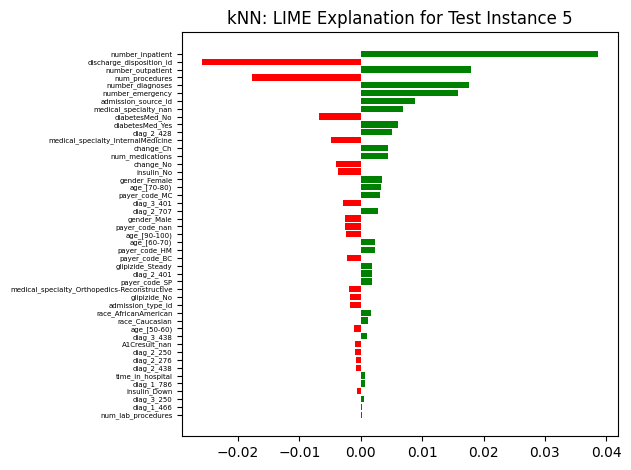

Instance 6
Predicted: <30
Actual:    NO


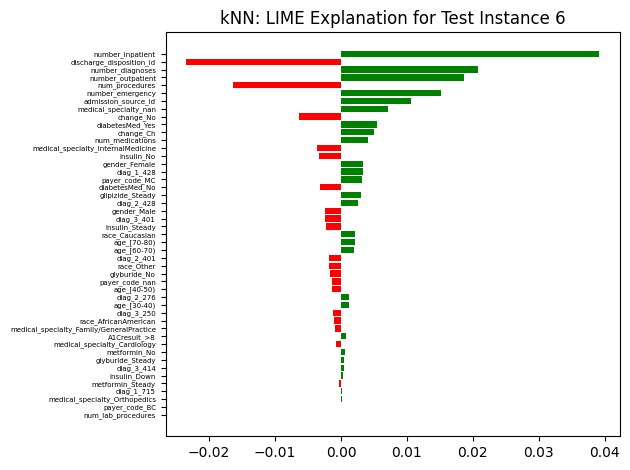

Instance 7
Predicted: <30
Actual:    NO


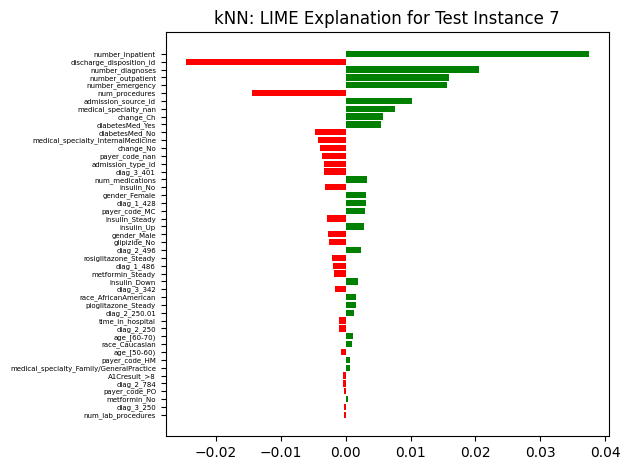

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsClassifier
from lime import lime_tabular

# Assume you already have:
# X_tr, X_val, X_te (pandas DataFrames)
# y_tr, y_val, y_te (pandas Series or DataFrames)
# preproc = your fitted ColumnTransformer

# Transform the datasets
X_tr_2 = preproc.transform(X_tr)
X_val_2 = preproc.transform(X_val)
X_te_2 = preproc.transform(X_te)

# Convert to dense numpy arrays if sparse
if hasattr(X_tr_2, "toarray"):
    X_tr_2_dense = X_tr_2.toarray()
    X_val_2_dense = X_val_2.toarray()
    X_te_2_dense = X_te_2.toarray()
else:
    X_tr_2_dense = np.array(X_tr_2)
    X_val_2_dense = np.array(X_val_2)
    X_te_2_dense = np.array(X_te_2)

# Flatten y labels to 1D array for sklearn
y_tr_array = y_tr.values.ravel()  # or y_tr.to_numpy().ravel()

# Train KNN classifier
knn = KNeighborsClassifier(n_neighbors=75)
knn.fit(X_tr_2_dense, y_tr_array)

# Extract feature names from ColumnTransformer
def get_feature_names_from_column_transformer(column_transformer):
    feature_names = []
    for name, transformer, columns in column_transformer.transformers_:
        if name != 'remainder':
            # unwrap pipeline if exists
            if hasattr(transformer, 'named_steps'):
                transformer = transformer.named_steps[list(transformer.named_steps.keys())[-1]]
            if hasattr(transformer, 'get_feature_names_out'):
                names = transformer.get_feature_names_out(columns)
            elif hasattr(transformer, 'get_feature_names'):
                names = transformer.get_feature_names(columns)
            else:
                names = columns
            feature_names.extend(names)
    return feature_names

feature_names = get_feature_names_from_column_transformer(preproc)
print(f"Number of features: {len(feature_names)}")

# Define your class names (adjust if needed)
class_names = ['NO', '>30', '<30']

# Create LIME explainer with dense data and disable discretize_continuous
explainer = lime_tabular.LimeTabularExplainer(
    training_data=X_tr_2_dense,
    feature_names=feature_names,
    class_names=class_names,
    mode='classification',
    discretize_continuous=False
)

for i in range(5,8):
    if hasattr(X_te_2[i], "toarray"):
        instance = X_te_2[i].toarray().ravel()
    else:
        instance = np.array(X_te_2[i])
    
    exp = explainer.explain_instance(
        data_row=instance,
        predict_fn=knn.predict_proba,
        num_features=47
    )
    
    print(f"Instance {i}")
    print("Predicted:", class_names[np.argmax(knn.predict_proba([instance])[0])])
    print("Actual:   ", y_te.values.ravel()[i])

    
    fig = exp.as_pyplot_figure()
    plt.yticks(fontsize=5)
    plt.title(f"kNN: LIME Explanation for Test Instance {i}")
    plt.tight_layout()
    plt.show()


Number of features: 2267
Instance 11
Predicted: <30
Actual:    NO


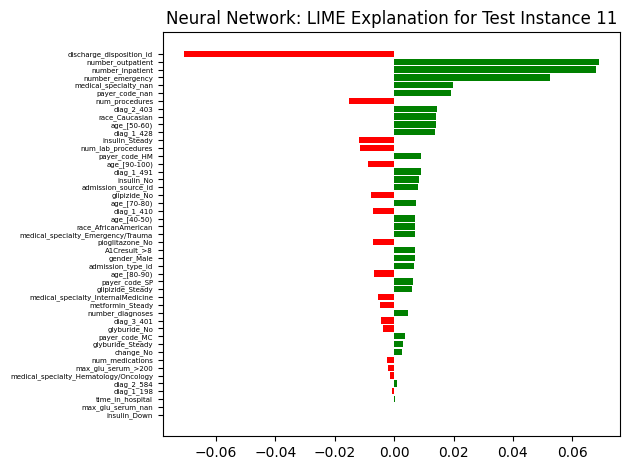

Instance 12
Predicted: >30
Actual:    NO


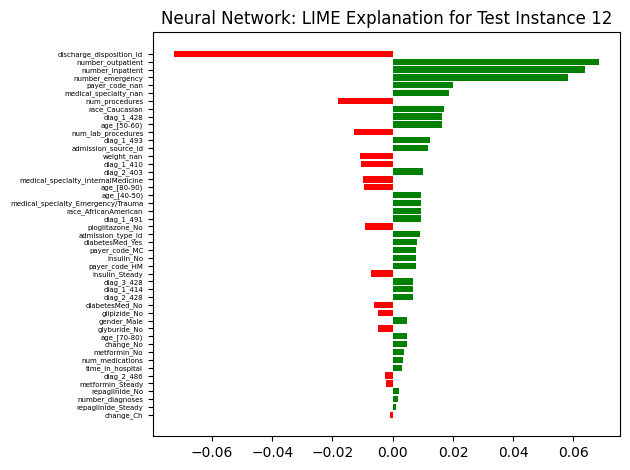

Instance 13
Predicted: <30
Actual:    NO


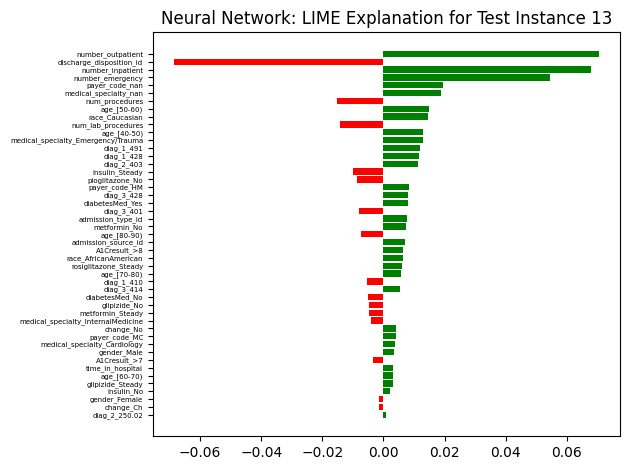

Instance 14
Predicted: >30
Actual:    >30


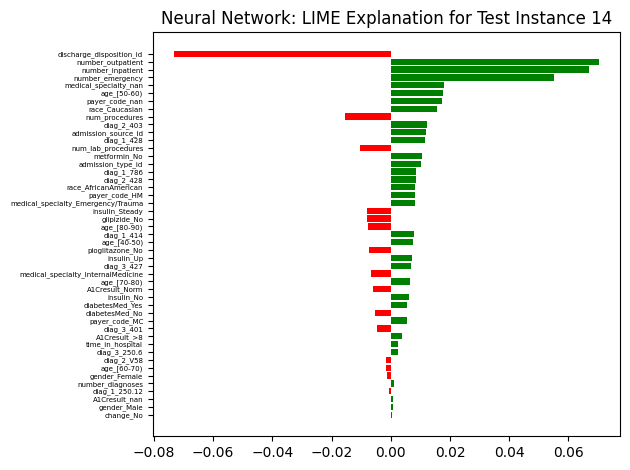

In [107]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.neural_network import MLPClassifier
from lime import lime_tabular

# Assume you already have:
# X_tr, X_val, X_te (pandas DataFrames)
# y_tr, y_val, y_te (pandas Series or DataFrames)
# preproc = your fitted ColumnTransformer

# Transform the datasets
X_tr_2 = preproc.transform(X_tr)
X_val_2 = preproc.transform(X_val)
X_te_2 = preproc.transform(X_te)

# Convert to dense numpy arrays if sparse
if hasattr(X_tr_2, "toarray"):
    X_tr_2_dense = X_tr_2.toarray()
    X_val_2_dense = X_val_2.toarray()
    X_te_2_dense = X_te_2.toarray()
else:
    X_tr_2_dense = np.array(X_tr_2)
    X_val_2_dense = np.array(X_val_2)
    X_te_2_dense = np.array(X_te_2)

# Flatten y labels to 1D array for sklearn
y_tr_array = y_tr.values.ravel()  # or y_tr.to_numpy().ravel()

# Train MLP classifier
mlp = MLPClassifier(solver='sgd', alpha=0.1, learning_rate_init=0.05, shuffle=True, random_state=hw1_seed, verbose=False)
mlp.fit(X_tr_2_dense, y_tr_array)

# Extract feature names from ColumnTransformer
def get_feature_names_from_column_transformer(column_transformer):
    feature_names = []
    for name, transformer, columns in column_transformer.transformers_:
        if name != 'remainder':
            # unwrap pipeline if exists
            if hasattr(transformer, 'named_steps'):
                transformer = transformer.named_steps[list(transformer.named_steps.keys())[-1]]
            if hasattr(transformer, 'get_feature_names_out'):
                names = transformer.get_feature_names_out(columns)
            elif hasattr(transformer, 'get_feature_names'):
                names = transformer.get_feature_names(columns)
            else:
                names = columns
            feature_names.extend(names)
    return feature_names

feature_names = get_feature_names_from_column_transformer(preproc)
print(f"Number of features: {len(feature_names)}")

# Define your class names (adjust if needed)
class_names = ['NO', '>30', '<30']

# Create LIME explainer with dense data and disable discretize_continuous
explainer = lime_tabular.LimeTabularExplainer(
    training_data=X_tr_2_dense,
    feature_names=feature_names,
    class_names=class_names,
    mode='classification',
    discretize_continuous=False
)

# Explain and plot for first 2 test instances
for i in range(11,15):
    # Get dense numpy array for the instance
    if hasattr(X_te_2[i], "toarray"):
        instance = X_te_2[i].toarray().ravel()
    else:
        instance = np.array(X_te_2[i])
    
    exp = explainer.explain_instance(
        data_row=instance,
        predict_fn=mlp.predict_proba,
        num_features=47
    )
    
    print(f"Instance {i}")
    print("Predicted:", class_names[np.argmax(mlp.predict_proba([instance])[0])])
    print("Actual:   ", y_te.values.ravel()[i])

    
    fig = exp.as_pyplot_figure()
    plt.yticks(fontsize=5)
    plt.title(f"Neural Network: LIME Explanation for Test Instance {i}")
    plt.tight_layout()
    plt.show()


Number of features: 2267
Instance 0
Predicted: <30
Actual:    NO


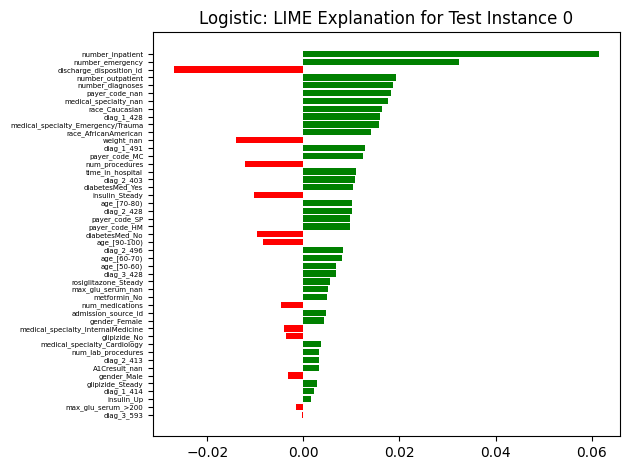

Instance 1
Predicted: <30
Actual:    NO


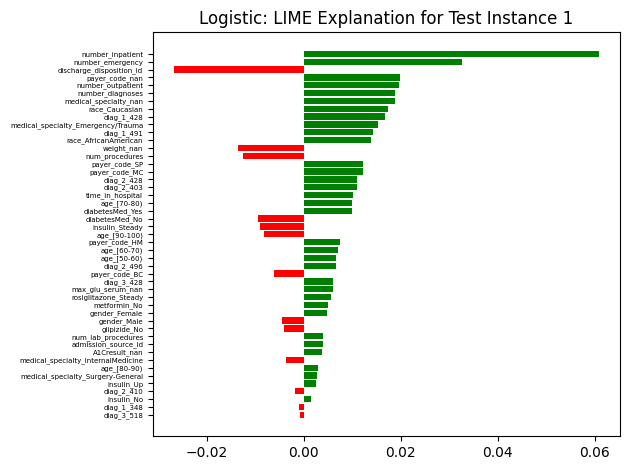

Instance 2
Predicted: <30
Actual:    NO


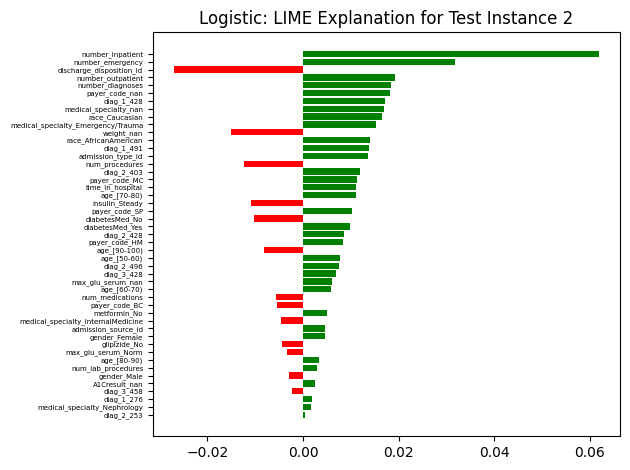

Instance 3
Predicted: >30
Actual:    >30


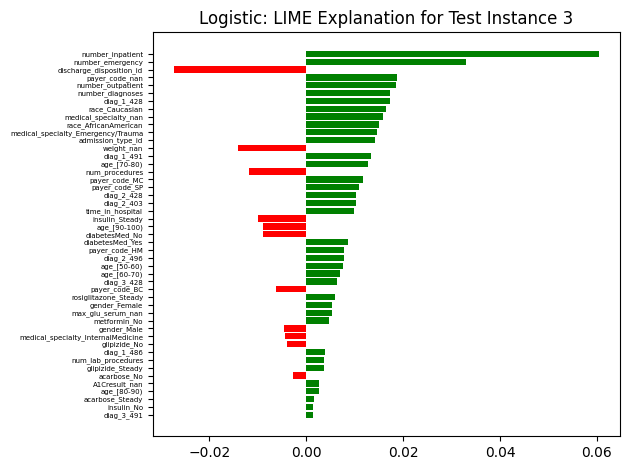

Instance 4
Predicted: <30
Actual:    NO


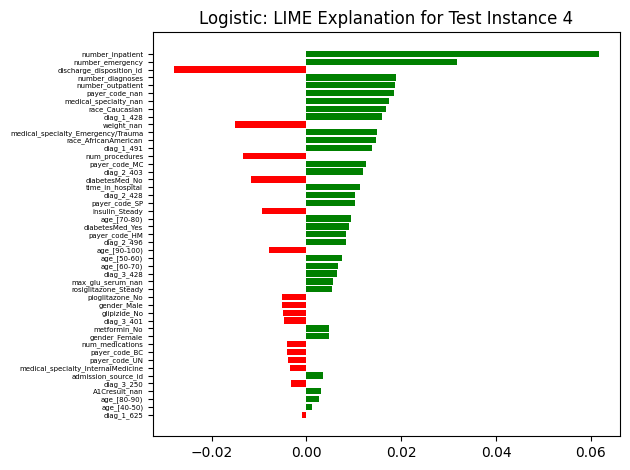

In [109]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from lime import lime_tabular

# Assume you already have:
# X_tr, X_val, X_te (pandas DataFrames)
# y_tr, y_val, y_te (pandas Series or DataFrames)
# preproc = your fitted ColumnTransformer

# Transform the datasets
X_tr_2 = preproc.transform(X_tr)
X_val_2 = preproc.transform(X_val)
X_te_2 = preproc.transform(X_te)

# Convert to dense numpy arrays if sparse
if hasattr(X_tr_2, "toarray"):
    X_tr_2_dense = X_tr_2.toarray()
    X_val_2_dense = X_val_2.toarray()
    X_te_2_dense = X_te_2.toarray()
else:
    X_tr_2_dense = np.array(X_tr_2)
    X_val_2_dense = np.array(X_val_2)
    X_te_2_dense = np.array(X_te_2)

# Flatten y labels to 1D array for sklearn
y_tr_array = y_tr.values.ravel()  # or y_tr.to_numpy().ravel()

# Train MLP classifier
log = LogisticRegression(C=0.01)
log.fit(X_tr_2_dense, y_tr_array)

# Extract feature names from ColumnTransformer
def get_feature_names_from_column_transformer(column_transformer):
    feature_names = []
    for name, transformer, columns in column_transformer.transformers_:
        if name != 'remainder':
            # unwrap pipeline if exists
            if hasattr(transformer, 'named_steps'):
                transformer = transformer.named_steps[list(transformer.named_steps.keys())[-1]]
            if hasattr(transformer, 'get_feature_names_out'):
                names = transformer.get_feature_names_out(columns)
            elif hasattr(transformer, 'get_feature_names'):
                names = transformer.get_feature_names(columns)
            else:
                names = columns
            feature_names.extend(names)
    return feature_names

feature_names = get_feature_names_from_column_transformer(preproc)
print(f"Number of features: {len(feature_names)}")

# Define your class names (adjust if needed)
class_names = ['NO', '>30', '<30']

# Create LIME explainer with dense data and disable discretize_continuous
explainer = lime_tabular.LimeTabularExplainer(
    training_data=X_tr_2_dense,
    feature_names=feature_names,
    class_names=class_names,
    mode='classification',
    discretize_continuous=False
)

# Explain and plot for first 2 test instances
for i in range(5):
    # Get dense numpy array for the instance
    if hasattr(X_te_2[i], "toarray"):
        instance = X_te_2[i].toarray().ravel()
    else:
        instance = np.array(X_te_2[i])
    
    exp = explainer.explain_instance(
        data_row=instance,
        predict_fn=log.predict_proba,
        num_features=47
    )
    
    print(f"Instance {i}")
    print("Predicted:", class_names[np.argmax(log.predict_proba([instance])[0])])
    print("Actual:   ", y_te.values.ravel()[i])

    
    fig = exp.as_pyplot_figure()
    plt.yticks(fontsize=5)
    plt.title(f"Logistic: LIME Explanation for Test Instance {i}")
    plt.tight_layout()
    plt.show()


In [19]:
#varsh
#logistic regression
def logistic_classification(X, y): 
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=seed)
    #  set the state of the random number generator so that we get the same results across runs when testing our code
     
    print('Number of training examples: ', X_train.shape[0])
    print('Number of testing examples: ', X_test.shape[0])   
    print('Vocabulary size: ', X_train.shape[1]) 

    ### YOUR CODE START HERE ### 

    # Specify the logistic classifier model
    # # Please use 'l1' penality type, 'liblinear' solver and enable fit_intercept
    classifier = LogisticRegression(penalty='l1', solver='liblinear', fit_intercept=True)

    # Train a logistic regression classifier and evaluate accuracy on the training data
    print('\nTraining a model with', X_train.shape[0], 'examples.....')
    # Training 
    classifier.fit(X_train, y_train)
    
    train_predictions = classifier.predict(X_train)
    train_accuracy = accuracy_score(y_train, train_predictions)
    print('\nTraining accuracy:',format( 100*train_accuracy , '.2f') ) 

    # Compute and print accuracy on the test data
    test_predictions = classifier.predict(X_test)
    test_accuracy = accuracy_score(y_test, test_predictions)

    ### YOUR CODE ENDS HERE ###
    print('\nTesting accuracy:', format( 100*test_accuracy , '.2f') )

    return classifier, train_accuracy, test_accuracy


#feedforward neural network

def train_mlp_with_hyperparameters(hyper_params, X_tr_10k, y_tr_10k, X_val_10k, y_val_10k, X_te_scaled, y_te, seed) -> Tuple[float, float, float]:
    mlp = MLPClassifier(**hyper_params, shuffle=True, random_state=seed, verbose=False)
    mlp.fit(X_tr_10k, y_tr_10k)
    train_accuracy = mlp.score(X_tr_10k, y_tr_10k)
    val_accuracy = mlp.score(X_val_10k, y_val_10k)
    test_accuracy = mlp.score(X_te_scaled, y_te)
    
    print('Hyperparameters performance:')
    print(f'Training accuracy: {train_accuracy}')
    print(f'Validation accuracy: {val_accuracy}')
    print(f'Test accuracy: {test_accuracy}')
    return train_accuracy, val_accuracy, test_accuracy

#for i, params in enumerate(param_list):
    #result = train_mlp_with_hyperparameters(params, X_tr_10k, y_tr_10k, X_val_10k, y_val_10k, X_te_scaled, y_te, seed)

def train_dt_with_hyperparameters(hyper_params, X_tr_10k, y_tr_10k, X_val_10k, y_val_10k, X_te_scaled, y_te, seed) -> Tuple[float, float, float]:
    mlp = DecisionTreeClassifier(**hyper_params, random_state=seed)
    mlp.fit(X_tr_10k, y_tr_10k)
    train_accuracy = mlp.score(X_tr_10k, y_tr_10k)
    val_accuracy = mlp.score(X_val_10k, y_val_10k)
    test_accuracy = mlp.score(X_te_scaled, y_te)
    
    """print('Hyperparameters performance:')
    print(f'Training accuracy: {train_accuracy}')
    print(f'Validation accuracy: {val_accuracy}')
    print(f'Test accuracy: {test_accuracy}')"""
    return train_accuracy, val_accuracy, test_accuracy

dt_param_list = [{"criterion": 'gini', 'max_depth': None, 'min_samples_leaf': 1, "max_features": None, 'ccp_alpha': 0.0, 'class_weight': None, 'splitter': 'best', 'min_samples_split': 2},
                 {"criterion": 'entropy', 'max_depth': None, 'min_samples_leaf': 1, "max_features": None, 'ccp_alpha': 0.0, 'class_weight': None, 'splitter': 'best', 'min_samples_split': 2},
                 {"criterion": 'log_loss', 'max_depth': None, 'min_samples_leaf': 1, "max_features": None, 'ccp_alpha': 0.0, 'class_weight': None, 'splitter': 'best', 'min_samples_split': 2},
                 {"criterion": 'gini', 'max_depth': 2, 'min_samples_leaf': 1, "max_features": None, 'ccp_alpha': 0.0, 'class_weight': None, 'splitter': 'best', 'min_samples_split': 2},
                 {"criterion": 'gini', 'max_depth': 5, 'min_samples_leaf': 1, "max_features": None, 'ccp_alpha': 0.0, 'class_weight': None, 'splitter': 'best', 'min_samples_split': 2},
                 {"criterion": 'gini', 'max_depth': 7, 'min_samples_leaf': 1, "max_features": None, 'ccp_alpha': 0.0, 'class_weight': None, 'splitter': 'best', 'min_samples_split': 2},
                 {"criterion": 'gini', 'max_depth': 8, 'min_samples_leaf': 1, "max_features": None, 'ccp_alpha': 0.0, 'class_weight': None, 'splitter': 'best', 'min_samples_split': 2},
                 {"criterion": 'gini', 'max_depth': 7, 'min_samples_leaf': 5, "max_features": None, 'ccp_alpha': 0.0, 'class_weight': None, 'splitter': 'best', 'min_samples_split': 2},
                 {"criterion": 'gini', 'max_depth': 7, 'min_samples_leaf': 10, "max_features": None, 'ccp_alpha': 0.0, 'class_weight': None, 'splitter': 'best', 'min_samples_split': 2},
                 {"criterion": 'gini', 'max_depth': 7, 'min_samples_leaf': 15, "max_features": None, 'ccp_alpha': 0.0, 'class_weight': None, 'splitter': 'best', 'min_samples_split': 2},
                 {"criterion": 'gini', 'max_depth': 7, 'min_samples_leaf': 30, "max_features": None, 'ccp_alpha': 0.0, 'class_weight': None, 'splitter': 'best', 'min_samples_split': 2},
                 {"criterion": 'gini', 'max_depth': 7, 'min_samples_leaf': 60, "max_features": None, 'ccp_alpha': 0.0, 'class_weight': None, 'splitter': 'best', 'min_samples_split': 2},
                 {"criterion": 'gini', 'max_depth': 7, 'min_samples_leaf': 75, "max_features": None, 'ccp_alpha': 0.0, 'class_weight': None, 'splitter': 'best', 'min_samples_split': 2},
                 {"criterion": 'gini', 'max_depth': 7, 'min_samples_leaf': 90, "max_features": None, 'ccp_alpha': 0.0, 'class_weight': None, 'splitter': 'best', 'min_samples_split': 2},
                 {"criterion": 'gini', 'max_depth': 7, 'min_samples_leaf': 100, "max_features": None, 'ccp_alpha': 0.0, 'class_weight': None, 'splitter': 'best', 'min_samples_split': 2},
                 {"criterion": 'gini', 'max_depth': 7, 'min_samples_leaf': 90, "max_features": 10, 'ccp_alpha': 0.0, 'class_weight': None, 'splitter': 'best', 'min_samples_split': 2},
                 {"criterion": 'gini', 'max_depth': 7, 'min_samples_leaf': 90, "max_features": None, 'ccp_alpha': 0.5, 'class_weight': None, 'splitter': 'best', 'min_samples_split': 2},
                 {"criterion": 'gini', 'max_depth': 7, 'min_samples_leaf': 90, "max_features": None, 'ccp_alpha': 1, 'class_weight': None, 'splitter': 'best', 'min_samples_split': 2},
                 {"criterion": 'gini', 'max_depth': 7, 'min_samples_leaf': 90, "max_features": None, 'ccp_alpha': 1, 'class_weight': 'balanced', 'splitter': 'best', 'min_samples_split': 2},
                 {"criterion": 'gini', 'max_depth': 7, 'min_samples_leaf': 90, "max_features": None, 'ccp_alpha': 1, 'class_weight': None, 'splitter': 'random', 'min_samples_split': 2},
                 {"criterion": 'gini', 'max_depth': 7, 'min_samples_leaf': 90, "max_features": None, 'ccp_alpha': 1, 'class_weight': None, 'splitter': 'best', 'min_samples_split': 10},
                 {"criterion": 'gini', 'max_depth': 7, 'min_samples_leaf': 90, "max_features": None, 'ccp_alpha': 1, 'class_weight': None, 'splitter': 'best', 'min_samples_split': 20},
                 ]

best_test = 0
best_param = None
result = []
for params in dt_param_list:
    train_accuracy, val_accuracy, test_accuracy = train_dt_with_hyperparameters(params, X_tr_2, y_tr, X_val_2, y_val, X_te_2, y_te, hw1_seed)
    if best_test< test_accuracy: 
        best_test = test_accuracy
        best_param = params
    result.append([params,[train_accuracy, val_accuracy, test_accuracy]])

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.width', 200)
pd.set_option('display.max_colwidth', None)


table_accuracies = []
for item in result:
    params, scores = item
    record = params.copy()
    record['train_score'] = scores[0]
    record['val_score'] = scores[1]
    record['test_score'] = scores[2]
    table_accuracies.append(record)

print("param", best_param)
print("test_accuracy", best_test)
df = pd.DataFrame(table_accuracies)
print(df)

param {'criterion': 'gini', 'max_depth': 7, 'min_samples_leaf': 100, 'max_features': None, 'ccp_alpha': 0.0, 'class_weight': None, 'splitter': 'best', 'min_samples_split': 2}
test_accuracy 0.5808194949395696
   criterion  max_depth  min_samples_leaf  max_features  ccp_alpha class_weight splitter  min_samples_split  train_score  val_score  test_score
0       gini        NaN                 1           NaN        0.0         None     best                  2     1.000000   0.492507    0.491795
1    entropy        NaN                 1           NaN        0.0         None     best                  2     1.000000   0.483909    0.483836
2   log_loss        NaN                 1           NaN        0.0         None     best                  2     1.000000   0.483909    0.483836
3       gini        2.0                 1           NaN        0.0         None     best                  2     0.564552   0.566305    0.564017
4       gini        5.0                 1           NaN        0.0      